In [47]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import os

api_key = os.environ["OPENWEATHER_API_KEY"]

df = pd.DataFrame()

In [143]:
# Function to get Lat and Lon from city name
def get_lat_lon(city, state, country):

    # API call
    params = {
        "q": ",".join([city, state, country]),
        "limit": "1",
        "appid": api_key
    }
    
    url = "http://api.openweathermap.org/geo/1.0/direct"

    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()
    data = r.json()

    # Catch ValueError
    if not data:
        raise ValueError(f"No results for {city},{state},{country}")

    # Pull Coordinates from response
    coors = {
        "lat": data[0]["lat"],
        "lon": data[0]["lon"]
    }
    
    return coors
    
location = ["New York", "NY", "US"]                            
result = get_lat_lon(*location)

print(result)

{'lat': 40.7127281, 'lon': -74.0060152}


In [131]:
def call_and_append(df, city):
    # Normalize city for consistent duplicate checks
    city_check = city.strip().lower()

    # If df already has the city, return df unchanged
    if 'city' in df.columns:
        existing_cities = df['city'].dropna().astype(str).str.strip().str.lower()
        if city_check in set(existing_cities):
            return df

    # API call
    params = {"q": city, "appid": api_key, "units": "imperial"}
    url = "https://api.openweathermap.org/data/2.5/forecast"

    response = requests.get(url, params=params, timeout=10)
    response.raise_for_status()
    data = response.json()

    # Build new df from API
    new_df = pd.json_normalize(data["list"], sep="_")

    df_weather = pd.json_normalize(new_df['weather'].str[0]).add_prefix("weather_")
    new_df = new_df.drop(columns=['weather']).join(df_weather)

    new_df['dt_txt'] = pd.to_datetime(new_df['dt_txt'])
    new_df['city'] = city.strip() 

    # Append and return
    return pd.concat([df, new_df], ignore_index=True)

In [133]:
df = call_and_append(df, "Newark")
print(df['city'].unique())

['Newark']


In [135]:
print(df.head())

           dt  visibility  pop              dt_txt  main_temp  \
0  1771988400     10000.0  0.0 2026-02-25 03:00:00      22.01   
1  1771999200     10000.0  0.0 2026-02-25 06:00:00      19.13   
2  1772010000     10000.0  0.0 2026-02-25 09:00:00      25.18   
3  1772020800      4574.0  0.2 2026-02-25 12:00:00      30.99   
4  1772031600       702.0  1.0 2026-02-25 15:00:00      32.38   

   main_feels_like  main_temp_min  main_temp_max  main_pressure  \
0            22.01          12.06          22.01           1015   
1            13.08          15.21          19.13           1014   
2            16.83          25.18          25.18           1009   
3            23.36          30.99          30.99           1007   
4            24.17          32.38          32.38           1006   

   main_sea_level  ...  wind_speed  wind_deg  wind_gust  sys_pod  snow_3h  \
0            1015  ...        1.52       189       1.95        n      NaN   
1            1014  ...        4.09       222      14

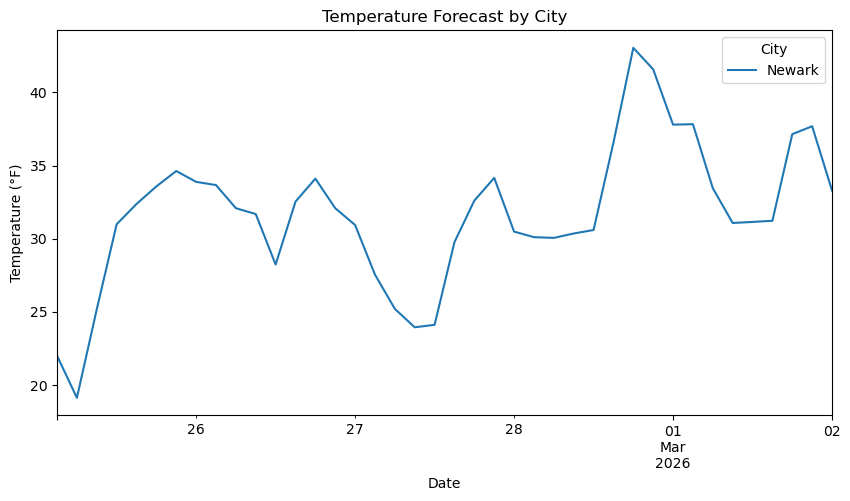

In [137]:
# Plot for various cities
pivot_df = df.pivot(index='dt_txt', columns='city', values='main_temp')

pivot_df.plot(figsize=(10,5))

plt.title("Temperature Forecast by City")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.legend(title="City")
plt.show()

In [ ]:
# For use later

# # Dictionary comperhension (USE THIS!) for look to check out what it's in items.
# filtered = {k:v for k, v in data.items() if k != "list"}

# city_data = data["city"]

# print(city_data)